In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
class TransactionGraphBuilder:
    """Build graph structure from transaction data"""
    
    def __init__(self):
        self.account_to_idx = {}
        self.idx_to_account = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def preprocess_features(self, df):
        """Enhanced feature preprocessing based on EDA insights"""
        df = df.copy()
        
        # Convert datetime
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        df['hour'] = df['datetime'].dt.hour.astype('int8')
        df['day_of_week'] = df['datetime'].dt.dayofweek.astype('int8')
        df['weekend'] = (df['day_of_week'] >= 5).astype('int8')

        # Log transform amount (from EDA)
        df['log_amount'] = np.log1p(df['Amount']).astype('float32')
        
        # Cross-border transactions (high risk factor from EDA)
        df['cross_border'] = (df['Sender_bank_location'] != df['Receiver_bank_location']).astype('int8')

        # Currency mismatch
        df['currency_mismatch'] = (df['Payment_currency'] != df['Received_currency']).astype('int8')

        # High-risk countries (from research paper)
        high_risk_countries = ['Mexico', 'Turkey', 'Morocco', 'UAE']
        df['sender_high_risk'] = df['Sender_bank_location'].isin(high_risk_countries).astype('int8')
        df['receiver_high_risk'] = df['Receiver_bank_location'].isin(high_risk_countries).astype('int8')
        
        # Suspicious time patterns (from EDA - after midnight to early morning)
        df['suspicious_hour'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype('int8')

        # Optimize memory usage
        df['Is_laundering'] = df['Is_laundering'].astype('int8')

        return df
    
    def calculate_graph_features(self, df):
        """Calculate fan-in, fan-out, and transaction frequency features"""
        # Combine all accounts
        all_accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
        all_accounts.sort()
        account_features = pd.DataFrame(index=all_accounts)

        # Fan-out: unique receivers per sender
        fan_out = df.groupby('Sender_account')['Receiver_account'].nunique().reset_index()
        fan_out.columns = ['account', 'fan_out']
        
        # Fan-in: unique senders per receiver
        fan_in = df.groupby('Receiver_account')['Sender_account'].nunique().reset_index()
        fan_in.columns = ['account', 'fan_in']
        
        # Transaction frequency as sender
        sender_freq = df.groupby('Sender_account').size().reset_index()
        sender_freq.columns = ['account', 'sender_frequency']
        
        # Transaction frequency as receiver
        receiver_freq = df.groupby('Receiver_account').size().reset_index()
        receiver_freq.columns = ['account', 'receiver_frequency']
        
        # Merge features
        account_features['fan_out'] = account_features.index.map(
            fan_out.set_index('account')['fan_out']
        )
        account_features['fan_in'] = account_features.index.map(
            fan_in.set_index('account')['fan_in']
        )
        account_features['sender_frequency'] = account_features.index.map(
            sender_freq.set_index('account')['sender_frequency']
        )
        account_features['receiver_frequency'] = account_features.index.map(
            receiver_freq.set_index('account')['receiver_frequency']
        )

        # Fill missing values
        account_features = account_features.fillna(0)

        del fan_out, fan_in, sender_freq, receiver_freq
        
        return account_features.reset_index().rename(columns={'index': 'account'})
    
    def encode_categorical_features(self, df, fit=True):
        """Encode categorical features"""
        categorical_cols = ['Payment_type', 'Sender_bank_location', 'Receiver_bank_location', 
                           'Payment_currency', 'Received_currency']
        
        for col in categorical_cols:
            if fit:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                encoded_values = self.label_encoders[col].fit_transform(df[col].astype(str))
            else:
                encoded_values = self.label_encoders[col].transform(df[col].astype(str))

            # Check if values fit in int8 range (0-127 for positive values)
            max_encoded = encoded_values.max()
            if max_encoded <= 127:
                df[f'{col}_encoded'] = encoded_values.astype('int8')
            elif max_encoded <= 32767:
                df[f'{col}_encoded'] = encoded_values.astype('int16')
                print(f"Warning: {col} has {max_encoded} unique values, using int16")
            else:
                df[f'{col}_encoded'] = encoded_values.astype('int32')
                print(f"Warning: {col} has {max_encoded} unique values, using int32")

        return df
    
    def clean_unwanted_features(self, df):
        """Remove unnecessary features"""
        unwanted_cols = ['Time', 'Payment_type', 'Sender_bank_location', 'Receiver_bank_location',
                         'Payment_currency', 'Received_currency', 'Amount', 'Laundering_type']
        df = df.drop(columns=unwanted_cols)
        return df

    def build_graph(self, df_train, df_val, df_test, max_nodes=50000):
        """Build graph from transaction data with memory optimization"""
        print("Preprocessing features...")
        df_train = self.preprocess_features(df_train)
        df_train = self.encode_categorical_features(df_train)
        df_train = self.clean_unwanted_features(df_train)

        df_val = self.preprocess_features(df_val)
        df_val = self.encode_categorical_features(df_val, fit=False)
        df_val = self.clean_unwanted_features(df_val)

        df_test = self.preprocess_features(df_test)
        df_test = self.encode_categorical_features(df_test, fit=False)
        df_test = self.clean_unwanted_features(df_test)
        
        # Sample data if too large for memory constraints
        if len(df_train) > max_nodes:
            print(f"Sampling {max_nodes} transactions from {len(df_train)} total")
            # Stratified sampling to maintain class balance
            suspicious = df_train[df_train['Is_laundering'] == 1]
            normal = df_train[df_train['Is_laundering'] == 0].sample(n=max_nodes-len(suspicious), random_state=42)
            df_train = pd.concat([suspicious, normal]).reset_index(drop=True)
        
        print("Building account mapping...")
        # Create account mappings
        train_accounts = list(set(df_train['Sender_account'].unique()) | set(df_train['Receiver_account'].unique()))
        val_accounts = list(set(df_val['Sender_account'].unique()) | set(df_val['Receiver_account'].unique()))
        test_accounts = list(set(df_test['Sender_account'].unique()) | set(df_test['Receiver_account'].unique()))
        all_accounts = list(set(train_accounts) | set(val_accounts) | set(test_accounts))
        self.account_to_idx = {acc: idx for idx, acc in enumerate(all_accounts)}
        self.idx_to_account = {idx: acc for acc, idx in self.account_to_idx.items()}
        
        print("Calculating graph features...")
        # Calculate account-level features
        account_features_train = self.calculate_graph_features(df_train)
        account_features_val = self.calculate_graph_features(df_val)
        account_features_test = self.calculate_graph_features(df_test)

        # Create node features matrix (All nodes must be included for transductive learning)
        num_nodes = len(all_accounts)
        node_features_train = np.zeros((num_nodes, 4))  # fan_out, fan_in, sender_freq, receiver_freq
        node_features_val = np.zeros((num_nodes, 4))
        node_features_test = np.zeros((num_nodes, 4))
        
        # Slow 
        for _, row in account_features_train.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_train[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]
        
        for _, row in account_features_val.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_val[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]

        for _, row in account_features_test.iterrows():
            idx = self.account_to_idx[row['account']]
            node_features_test[idx] = [row['fan_out'], row['fan_in'], 
                                row['sender_frequency'], row['receiver_frequency']]

        print("Creating edges and edge features...")

        feature_columns = [
                'log_amount', 'hour', 'day_of_week', 'weekend', 'cross_border',
                'currency_mismatch', 'sender_high_risk', 'receiver_high_risk',
                'suspicious_hour', 'Payment_type_encoded', 'Sender_bank_location_encoded',
                'Receiver_bank_location_encoded'
                ]

        # Create edge list and edge features
        edge_list_train = np.column_stack((df_train['Sender_account'].map(self.account_to_idx), 
                                           df_train['Receiver_account'].map(self.account_to_idx)))
        edge_features_train = df_train[feature_columns].values
        edge_labels_train = df_train['Is_laundering'].values
        edge_list_val = np.column_stack((df_val['Sender_account'].map(self.account_to_idx), 
                                         df_val['Receiver_account'].map(self.account_to_idx)))
        edge_features_val = df_val[feature_columns].values
        edge_labels_val = df_val['Is_laundering'].values
        edge_list_test = np.column_stack((df_test['Sender_account'].map(self.account_to_idx), 
                                         df_test['Receiver_account'].map(self.account_to_idx)))
        edge_features_test = df_test[feature_columns].values
        edge_labels_test = df_test['Is_laundering'].values
        
        # Convert to tensors (Train, Val, Test)
        edge_index_train = torch.tensor(edge_list_train, dtype=torch.long).t().contiguous()
        node_features_train = torch.tensor(node_features_train, dtype=torch.float)
        edge_features_train = torch.tensor(edge_features_train, dtype=torch.float)
        edge_labels_train = torch.tensor(edge_labels_train, dtype=torch.long)

        edge_index_val = torch.tensor(edge_list_val, dtype=torch.long).t().contiguous()
        node_features_val = torch.tensor(node_features_val, dtype=torch.float)
        edge_features_val = torch.tensor(edge_features_val, dtype=torch.float)
        edge_labels_val = torch.tensor(edge_labels_val, dtype=torch.long)

        edge_index_test = torch.tensor(edge_list_test, dtype=torch.long).t().contiguous()
        node_features_test = torch.tensor(node_features_test, dtype=torch.float)
        edge_features_test = torch.tensor(edge_features_test, dtype=torch.float)
        edge_labels_test = torch.tensor(edge_labels_test, dtype=torch.long)

        # Standardize features
        node_features_train = torch.tensor(self.scaler.fit_transform(node_features_train), dtype=torch.float)
        node_features_val = torch.tensor(self.scaler.transform(node_features_val), dtype=torch.float)
        node_features_test = torch.tensor(self.scaler.transform(node_features_test), dtype=torch.float)
        edge_features_train = torch.tensor(self.scaler.fit_transform(edge_features_train), dtype=torch.float)
        edge_features_val = torch.tensor(self.scaler.transform(edge_features_val), dtype=torch.float)
        edge_features_test = torch.tensor(self.scaler.transform(edge_features_test), dtype=torch.float)
        
        # Create PyTorch Geometric data object
        train_data = Data(
            x=node_features_train,
            edge_index=edge_index_train,
            edge_attr=edge_features_train,
            y=edge_labels_train
        )
        val_data = Data(
            x=node_features_val,
            edge_index=edge_index_val,
            edge_attr=edge_features_val,
            y=edge_labels_val
        )
        test_data = Data(
            x=node_features_test,
            edge_index=edge_index_test,
            edge_attr=edge_features_test,
            y=edge_labels_test
        )

        print(f"Graph created: {num_nodes} nodes.")
        print(f"Suspicious transactions in train set: {edge_labels_train.sum().item()} ({edge_labels_train.float().mean()*100:.3f}%)")
        print(f"Suspicious transactions in val set: {edge_labels_val.sum().item()} ({edge_labels_val.float().mean()*100:.3f}%)")
        print(f"Suspicious transactions in test set: {edge_labels_test.sum().item()} ({edge_labels_test.float().mean()*100:.3f}%)")

        return train_data, val_data, test_data

In [4]:
# Model
class GraphSAGE(nn.Module):
    """GraphSAGE model for transaction classification"""
    
    def __init__(self, num_node_features, num_edge_features, hidden_dim=128, num_layers=3, dropout=0.3):
        super(GraphSAGE, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Node embedding layers
        self.node_convs = nn.ModuleList()
        self.node_convs.append(SAGEConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 1):
            self.node_convs.append(SAGEConv(hidden_dim, hidden_dim))
        
        # Edge feature processing
        self.edge_mlp = nn.Sequential(
            nn.Linear(num_edge_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # sender + receiver + edge features
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 2)
        )
        
    def forward(self, x, edge_index, edge_attr, batch=None):
        # Node embeddings through GraphSAGE layers
        h = x
        for i, conv in enumerate(self.node_convs):
            h = conv(h, edge_index)
            if i < len(self.node_convs) - 1:
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Process edge features
        edge_emb = self.edge_mlp(edge_attr)
        
        # Combine sender and receiver embeddings with edge features
        sender_emb = h[edge_index[0]]  # Sender embeddings
        receiver_emb = h[edge_index[1]]  # Receiver embeddings
        
        # Concatenate all features
        combined = torch.cat([sender_emb, receiver_emb, edge_emb], dim=1)
        
        # Final classification
        out = self.classifier(combined)
        
        return out

In [5]:
class AMLTrainer:
    """Training pipeline for AML detection"""
    
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        
    def train_epoch(self, data, optimizer, criterion):
        self.model.train()
        optimizer.zero_grad()
        
        out = self.model(data.x, data.edge_index, data.edge_attr)
        
        # Apply class weights for imbalanced data
        weight = self.class_weights.to(self.device)
        loss = F.cross_entropy(out, data.y, weight=weight)
        
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    def evaluate(self, data):
        self.model.eval()
        with torch.no_grad():
            out = self.model(data.x, data.edge_index, data.edge_attr)
            pred = out.argmax(dim=1)

            # Calculate loss (weighted, for consistency with training)
            weight = self.class_weights.to(self.device)
            loss = F.cross_entropy(out, data.y, weight=weight).item()
            
            # Calculate metrics
            y_true = data.y.cpu().numpy()
            y_pred = pred.cpu().numpy()
            y_prob = F.softmax(out, dim=1)[:, 1].cpu().numpy()
            
            accuracy = (pred == data.y).float().mean().item()
            recall = recall_score(y_true, y_pred, average='binary')
            f2 = fbeta_score(y_true, y_pred, beta=2, average='binary')  # F2 score with beta=2
            
            return loss, accuracy, recall, f2, y_true, y_pred, y_prob
    
    def train(self, train_data, val_data, epochs=100, lr=0.001, patience=10):
        # Calculate class weights for imbalanced data
        _class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(train_data.y.cpu().numpy()), 
            y=train_data.y.cpu().numpy()
        )
        # Fine-tune weight to balance precision and recall
        _class_weights[1] *= 0.8  # Increase weight for laundering class to boost recall
        self.class_weights = torch.tensor(_class_weights, dtype=torch.float).to(self.device)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, factor=0.5, mode='max' # Mode 'max' for F2 score
        )
        
        best_f2 = 0
        patience_counter = 0
        train_losses = []
        val_losses = []
        val_f2s = []
        
        print("Starting training...")
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_data, optimizer, F.cross_entropy)
            
            # Validation
            val_loss, val_acc, val_recall, val_f2, _, _, _ = self.evaluate(val_data)

            scheduler.step(val_f2)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_f2s.append(val_f2)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:03d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Recall: {val_recall:.4f}, Val F2: {val_f2:.4f}')

            # Early stopping
            if val_f2 > best_f2:
                best_f2 = val_f2
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pt'))
        print(f'Training completed. Best validation F2: {best_f2:.4f}')

        return train_losses, val_losses, val_f2s

In [ ]:
# Load dataset (Using Min's data files)
df_train = pd.read_csv('tmp/train.csv')
df_val = pd.read_csv('tmp/val.csv')
df_test = pd.read_csv('tmp/test.csv')

In [13]:
print(f"Dataset shape train: {df_train.shape}")
print(f"Suspicious transactions: {df_train['Is_laundering'].sum()} ({df_train['Is_laundering'].mean()*100:.4f}%)")

print(f"Dataset shape val: {df_val.shape}")
print(f"Suspicious transactions: {df_val['Is_laundering'].sum()} ({df_val['Is_laundering'].mean()*100:.4f}%)")

print(f"Dataset shape test: {df_test.shape}")
print(f"Suspicious transactions: {df_test['Is_laundering'].sum()} ({df_test['Is_laundering'].mean()*100:.4f}%)")

Dataset shape train: (7604163, 13)
Suspicious transactions: 7898 (0.1039%)
Dataset shape val: (950572, 13)
Suspicious transactions: 988 (0.1039%)
Dataset shape test: (950117, 13)
Suspicious transactions: 987 (0.1039%)


In [15]:
# Build graph
graph_builder = TransactionGraphBuilder()
train_graph, val_graph, test_graph = graph_builder.build_graph(df_train, df_val, df_test, max_nodes=10000000)

Preprocessing features...
Building account mapping...
Calculating graph features...
Creating edges and edge features...
Graph created: 855460 nodes.
Suspicious transactions in train set: 7898 (0.104%)
Suspicious transactions in val set: 988 (0.104%)
Suspicious transactions in test set: 987 (0.104%)


In [16]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(
    num_node_features=train_graph.x.shape[1],
    num_edge_features=train_graph.edge_attr.shape[1],
    hidden_dim=128,
    num_layers=3,
    dropout=0.3
)
    
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 142,786


In [17]:
# Move data to device
train_graph = train_graph.to(device)
val_graph = val_graph.to(device)
test_graph = test_graph.to(device)

In [19]:
# Train model
trainer = AMLTrainer(model, device)
train_losses, val_losses, val_f2s = trainer.train(train_graph, val_graph, epochs=100, lr=0.001)

Starting training...
Epoch 000: Train Loss: 0.7139, Val Loss: 0.6687, Val Recall: 0.2449, Val F2: 0.0323
Epoch 010: Train Loss: 0.2700, Val Loss: 0.1916, Val Recall: 0.9889, Val F2: 0.0577
Epoch 020: Train Loss: 0.1045, Val Loss: 0.0790, Val Recall: 0.9960, Val F2: 0.0998
Epoch 030: Train Loss: 0.0616, Val Loss: 0.0514, Val Recall: 0.9970, Val F2: 0.1716
Epoch 040: Train Loss: 0.0504, Val Loss: 0.0356, Val Recall: 0.9970, Val F2: 0.2772
Epoch 050: Train Loss: 0.0354, Val Loss: 0.0256, Val Recall: 0.9980, Val F2: 0.2738
Epoch 060: Train Loss: 0.0311, Val Loss: 0.0253, Val Recall: 0.9767, Val F2: 0.6865
Epoch 070: Train Loss: 0.0272, Val Loss: 0.0241, Val Recall: 0.9777, Val F2: 0.7150
Epoch 080: Train Loss: 0.0271, Val Loss: 0.0254, Val Recall: 0.9777, Val F2: 0.6390
Early stopping at epoch 81
Training completed. Best validation F2: 0.7247


In [20]:
# Evaluate on test set
test_loss, test_acc, test_recall, test_f2, y_true, y_pred, y_prob = trainer.evaluate(test_graph)

print(f"\nTest Results:")
print(f"Recall: {test_recall:.4f}")
print(f"F2 Score: {test_f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Suspicious']))


Test Results:
Recall: 0.9909
F2 Score: 0.6658

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    949130
  Suspicious       0.29      0.99      0.45       987

    accuracy                           1.00    950117
   macro avg       0.64      0.99      0.72    950117
weighted avg       1.00      1.00      1.00    950117



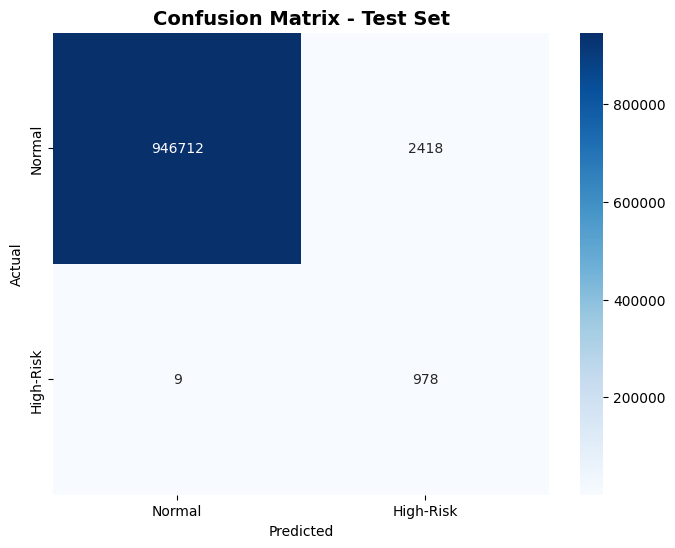

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

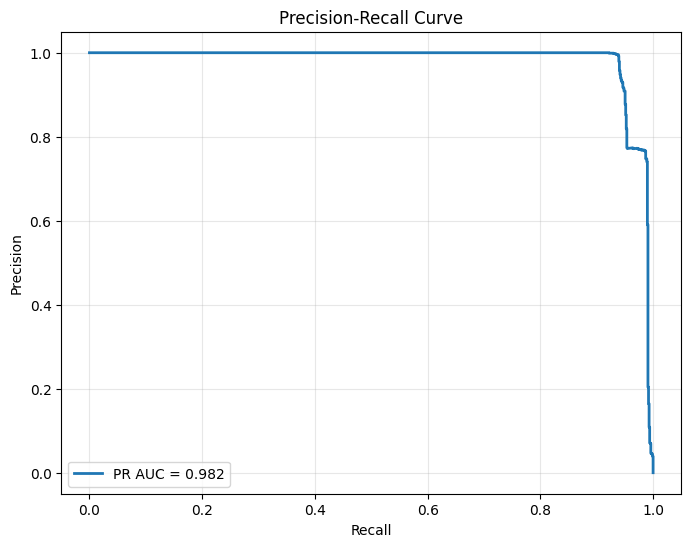

PR AUC Score: 0.9816


In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate PR curve data
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PR AUC Score: {pr_auc:.4f}")


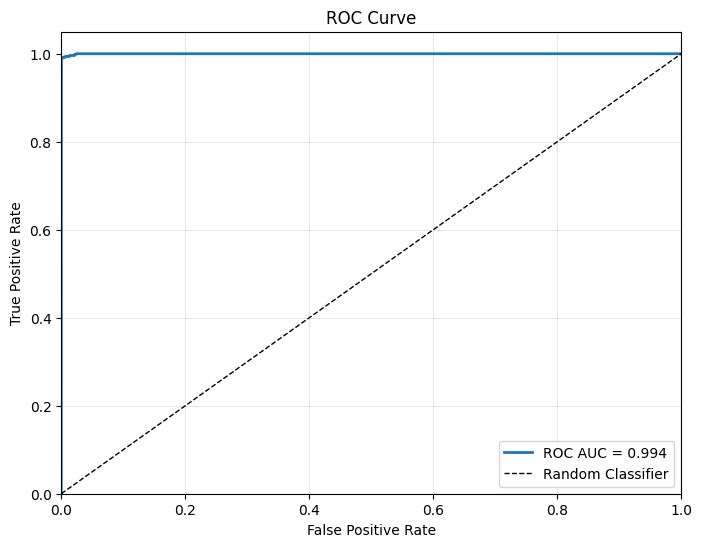

ROC AUC Score: 0.9942


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

In [24]:
for threshold in [0.5, 0.8, 0.9, 0.95, 0.99]:
    y_pred = (y_prob >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Threshold: {threshold}, precision: {precision}, recall: {recall}")

Threshold: 0.5, precision: 0.2879858657243816, recall: 0.9908814589665653
Threshold: 0.8, precision: 0.5997544505831799, recall: 0.9898682877406282
Threshold: 0.9, precision: 0.7416413373860182, recall: 0.9888551165146909
Threshold: 0.95, precision: 0.773061224489796, recall: 0.9594731509625126
Threshold: 0.99, precision: 1.0, recall: 0.8530901722391084
